<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº3: Estimación Espectral y Ventanas
#### Ariel Hipólito


# Introducción:

En este notebook se simula una señal senoidal ruidosa y se estudia la 
estimación de amplitud y frecuencia utilizando la Transformada Discreta de Fourier (DFT) 
con distintas ventanas (rectangular, Hann, Blackman-Harris y Flattop).  

El objetivo es analizar el sesgo y la varianza de los estimadores bajo distintos 
niveles de relación señal-ruido (SNR = 3 dB y 10 dB).

## Modelo de señal

La señal simulada se define como:



\begin{equation}
x(n) = a_0 \cdot \sin(\Omega_1 n) + n_q(n)
\end{equation}



Donde:
- $ a_0 = \sqrt{2}$ : es la amplitud (potencia = 1 W).
- $\Omega_0 = \frac{\pi}{2}$ : es la frecuencia central.
- $\Omega_1 = \Omega_0 + f_r \cdot \frac{\pi}{2N}$, con  $f_r \sim U(-2, 2)$
- $ n_q(n) \sim \mathcal{N}(0, \sigma^2)$ es ruido blanco gaussiano.

Se simulan 200 realizaciones de 1000 muestras cada una, para dos niveles de SNR: 3 dB y 10 dB.

Primero vamos abordar ciertos temas como el **zero-ṕadding** y la **normalización de amplitud** de las señales.

- - - 

## ZERO-PADDING:

Es una tecnica que consiste basicamente en **agregar ceros al final de la señal en el dominio temporal** antes de calcular la FFT con el fin de mejorar la estimación de frecuencia de picos y obtener graficos más claros para comparar con mayor detalle ventanas y efectos de desparramo hacia frecuencias vecinas por lo que la energía de una señal no se concentra en un único bin de la DFT (*leakage*).

La DFT de longitud $N$ evalúa la transformada de Fourier en $N$ frecuencias discretas.
Si se aumenta a $N_{fft} > N$ se obtienen más puntos en la grilla de frecuencias.
Es decir, la FFT queda más “densa” por lo que te da mejor visualización de los picos.

\begin{equation}
X[k] = \sum_{n=0}^{N-1} x[n] \, e^{-j \frac{2\pi kn}{N}}
\end{equation}

Si se extiende a $N_{fft}$, la definición es la misma, pero se evalúa en una grilla de frecuencias más fina: $\Delta \omega = \frac{2\pi}{N_{fft}}$

Interpolando la DFT se logra ubicar mejor el pico real dado que $\Delta f = \frac{f_s}{N}$ por lo que mientras mas grande sea nuestro $N$ mas acotado será nuestro $\Delta f$.

Y todo esto lo hace sin:

- Cambiar la información real de la señal.
- Mejorar la relación señal-ruido (SNR).
- Aumentar la resolución física del muestreo.

- - -

## NORMALIZACION DE LA AMPLITUD: 

Cuando se realiza la FFT de una señal $x[n]$, el valor que aparece en un bin $k$ no es directamente la amplitud de la senoidal.

\begin{equation}
x[n] = a \cdot \sin(\omega_0 n), \quad n = 0, \ldots, N - 1
\end{equation}

Si se aplica la FFT (sin ventana, sin ruido, sin normalización) y justo la frecuencia coincide con un bin, el valor de ese bin va a ser aproximadamente:

\begin{equation}
|X[k_0]| \approx \frac{a \cdot N}{2}
\end{equation}

Es decir la magnitud en el dominio frecuencial crece con $N$ y no es igual a $a$ por lo que para que el estimador de amplitud sea consistente con el valor real de la senoidal es necesario dividir por ese factor.

Cuando además se aplica una ventana $w[n]$ (Hann, Blackman, etc.), ya no se tiene la suma exacta, sino que cada muestra se multiplica por un coeficiente distinto.

Entonces el valor del bin se aproxima a:
\begin{equation}
|X[k_0]| \approx \frac{a \cdot N \cdot G_w}{2} ; \quad G_w = \frac{1}{N} \sum_{n=0}^{N-1} w[n]
\end{equation}

Siendo $G_w$ la ganancia coherente de la ventana (básicamente cuánto “baja” la amplitud de la senoidal al aplicar esa ventana).

Teniendo esto en cuenta podremos obtener un estimador insesgado de la amplitud real $a$, haciendo la corrección inversa:
\begin{equation}
\hat{a} = \frac{2}{N \cdot G_w} \cdot |X_w[k_0]|
\end{equation}

De esta manera evitamos resultados engañosos dado que si no se realizara la normalizacion:
- Los histogramas y valores de sesgo/varianza de amplitud van a estar desplazados respecto al valor verdadero $a$.
- El estimador daría amplitudes mucho más grandes o más chicas, dependiendo de $N$ y de la ventana elegida.

Por ejemplo si tuvieramos una señal de amplitud $a=1$, con $N=1000$ y con una ventana rectangular donde $G_w=1$. El bin de FFT daría $∣X[k0]∣≈500$. Es decir que sin la normalización la amplitud sería 500 en lugar de 1.

- - -

Empezaremos declarando las variables globales: 

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window

# Parámetros globales
N = 1000
M = 200
fs = N
omega0 = np.pi / 2
a0 = np.sqrt(2)
SNR_dbs = [3, 10]

# Ventanas a analizar
ventanas = {
    "rectangular": np.ones(N),
    "flattop": get_window("flattop", N),
    "blackmanharris": get_window("blackmanharris", N),
    "hann": get_window("hann", N)
}

tt = np.arange(N)

## Simulación y estimación

Se genera la señal senoidal con ruido para cada realización, y se aplica cada ventana antes de calcular la FFT. Luego se estiman:

- **Amplitud**: usando el valor de la FFT en $\Omega_0$
- **Frecuencia**: como el índice del máximo espectral.

Se calculan el sesgo y la varianza de cada estimador para cada ventana y SNR sin tener en cuenta el zero-padding ni la ganancia de la ventana.


In [103]:
def superposicion_show(snr_dbs, N_fft):
    
    for snr_db in snr_dbs:
        
        print(f"\n### Simulación con SNR = {snr_db} dB ###\n")

        #Varianza del ruido para el SNR prescrito
        sigma2 = a0**2 / (2*(10**(snr_db/10)))

        # Frecuencias aleatorias alrededor de omega0
        frs = np.random.uniform(-2, 2, M)
        omega1 = omega0 + frs * 2 * np.pi / N
    
        # Expandir dimensiones
        tt_matricial = np.tile(tt.reshape(N, 1), (1, M))
        omega1_matricial = np.tile(omega1.reshape(1, M), (N, 1))
        
        # Señal senoidal + ruido
        sin = a0 * np.sin(omega1_matricial * tt_matricial)
        ruido = np.random.normal(0, np.sqrt(sigma2), (N, M))
        sin_ruidosa = sin + ruido
        
        freqs = np.fft.fftfreq(N_fft, d=1)[0:N_fft//2] * N
    
        # Gráficos
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        axs = axs.flatten()
    
        for i, (nombre, w) in enumerate(ventanas.items()):
            # Aplicar ventana
            w_matricial = np.tile(w.reshape(N,1), (1, M))
            sin_w = sin_ruidosa * w_matricial
            
            # FFT
            Xw = np.fft.fft(sin_w, N_fft, axis=0)
            mag = np.abs(Xw[0:N_fft//2, :]) 
            mag = mag / np.max(mag, axis=0, keepdims=True)
    
            #Graficar cada realización
            for j in range(M):
                axs[i].plot(freqs[:N_fft//2], mag[:, j])
    
            axs[i].set_title(f"Ventana {nombre} - Superposición de {M} fits")
            axs[i].set_xlim(240, 260)
            axs[i].set_ylim(0, 1.1)
            axs[i].set_xlabel("Frecuencia (muestras)")
            axs[i].set_ylabel("Magnitud normalizada")
    
        plt.tight_layout()
        plt.show()
    return 


### Simulación con SNR = 3 dB ###



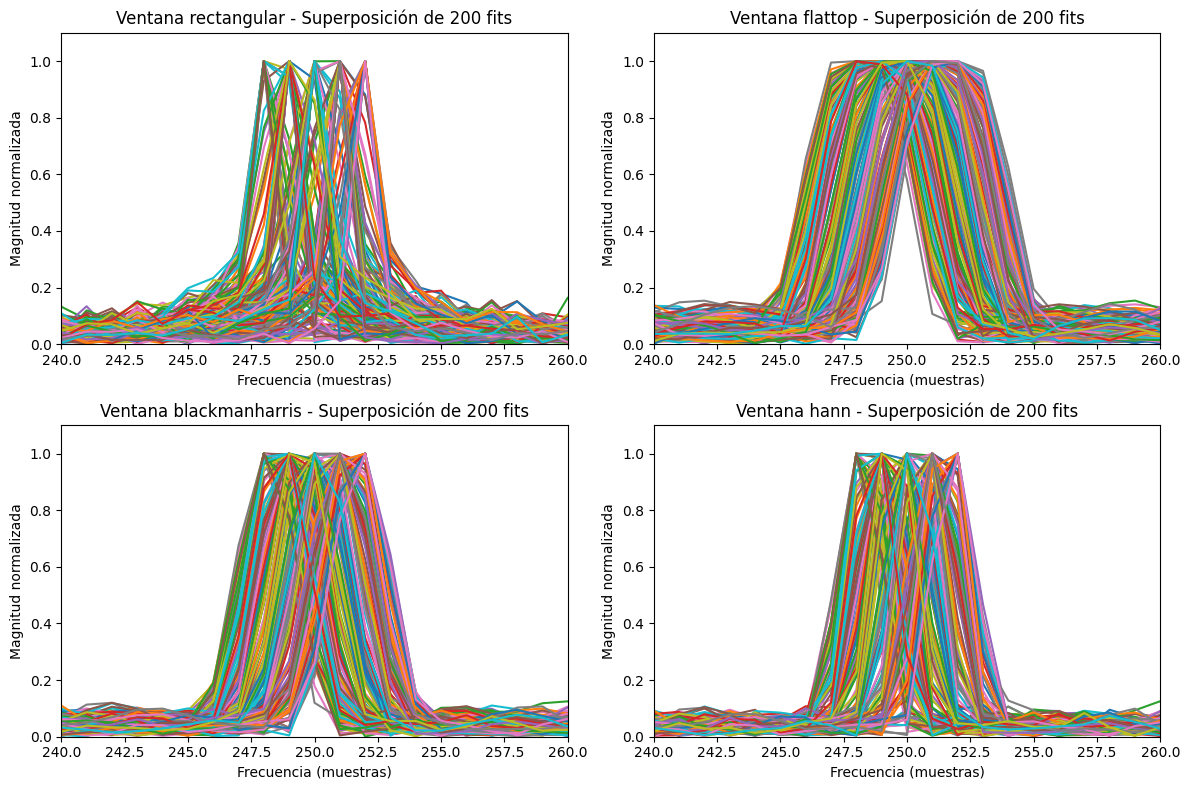


### Simulación con SNR = 10 dB ###



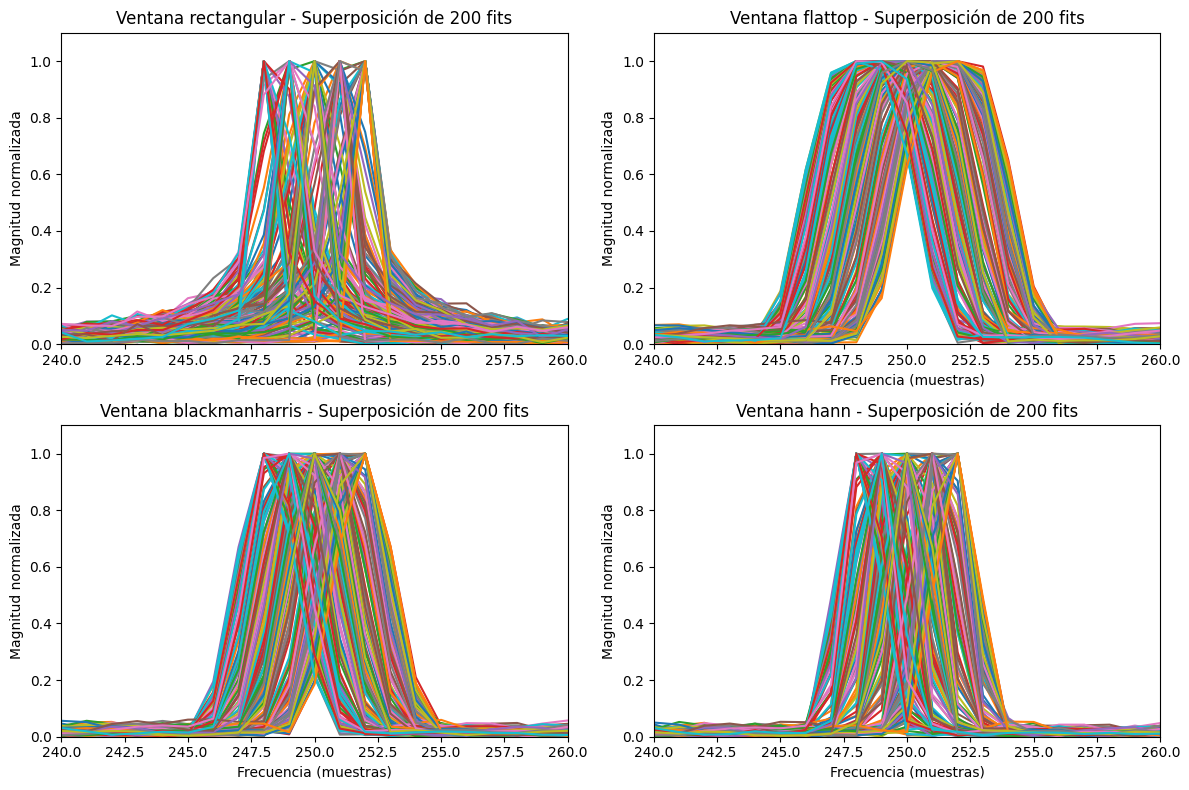

In [104]:
superposicion_show(SNR_dbs, N_fft=N)

In [128]:
def estimadores_show(snr_dbs, w, N_fft, normalizado="si"):
    
    for snr_db in snr_dbs:
    
        print(f"\n### Simulación con SNR = {snr_db} dB ###\n")
    
        # Varianza del ruido para el SNR prescrito
        sigma2 = a0**2 / (2*(10**(snr_db/10)))
    
        # Frecuencias aleatorias alrededor de omega0
        frs = np.random.uniform(-2, 2, M)
        omega1 = omega0 + frs * 2 * np.pi / N

        # Expandir dimensiones
        tt_matricial = np.tile(tt.reshape(N, 1), (1, M))
        omega1_matricial = np.tile(omega1.reshape(1, M), (N, 1))
    
        # Señal senoidal + ruido
        sin = a0 * np.sin(omega1_matricial * tt_matricial)
        ruido = np.random.normal(0, np.sqrt(sigma2), (N, M))
        sin_ruidosa = sin + ruido
    
        for nombre, w in ventanas.items():
        
            print(f"  Ventana: {nombre}\n")
            
            # Aplicar ventana
            w_matricial = np.tile(w.reshape(N,1), (1, M))
            sin_w = sin_ruidosa * w_matricial
        
            # FFT
            Xw = np.fft.fft(sin_w, N_fft, axis=0)

            # Solo mitad positiva del espectro
            freqs = np.fft.fftfreq(N_fft, d=1/fs)
            pos_mask = freqs >= 0
            freqs = freqs[pos_mask]
            Xw = Xw[pos_mask, :]
        
            # Estimadores
            idx0 = np.argmin(np.abs(freqs - omega0 * fs/(2*np.pi)))  # en Hz
            if normalizado == "si":
                Gw = np.sum(w) / N   # Ganancia de la ventana
                estim_amplitud = (2 / (N * Gw)) * np.abs(Xw[idx0, :])
            else: 
                estim_amplitud = np.abs(Xw[idx0, :])
        
            idx_max = np.argmax(np.abs(Xw), axis=0)
            estim_frec = freqs[idx_max]
        
            # Estadísticos
            mu_a = np.mean(estim_amplitud)
            sesgo_a = mu_a - a0
            var_a = np.var(estim_amplitud)
        
            mu_f = np.mean(estim_frec)
            mu_f_teo = np.mean(omega1 * fs / (2*np.pi))  # frecuencia real en Hz
            sesgo_f = mu_f - mu_f_teo
            var_f = np.var(estim_frec)

            print(f"    Amplitud: sesgo={sesgo_a:.4f}, var={var_a:.4f}")
            print(f"    Frecuencia: sesgo={sesgo_f:.4e}, var={var_f:.4e}\n")
        
            # ---- HISTOGRAMAS ----
        
            # Amplitud en dB
            estim_amp_db = 20*np.log10(estim_amplitud + 1e-12)
        
            plt.figure(figsize=(10,4))
            plt.hist(estim_amp_db, bins=30, color="skyblue", edgecolor="k")
            plt.title(f"Histograma de amplitud estimada (dB)\nVentana: {nombre}, SNR={snr_db} dB")
            plt.xlabel("Amplitud estimada [dB]")
            plt.ylabel("Frecuencia de ocurrencia")
            plt.grid(True)
            plt.show()
        
            # Frecuencia en Hz
            plt.figure(figsize=(10,4))
            plt.hist(estim_frec, bins=30, color="salmon", edgecolor="k")
            plt.title(f"Histograma de frecuencia estimada (Hz)\nVentana: {nombre}, SNR={snr_db} dB")
            plt.xlabel("Frecuencia estimada [Hz]")
            plt.ylabel("Frecuencia de ocurrencia")
            plt.grid(True)
            plt.show()
    
    return




### Simulación con SNR = 3 dB ###

  Ventana: rectangular

    Amplitud: sesgo=258.4366, var=53840.9255
    Frecuencia: sesgo=1.0836e-02, var=1.5164e+00



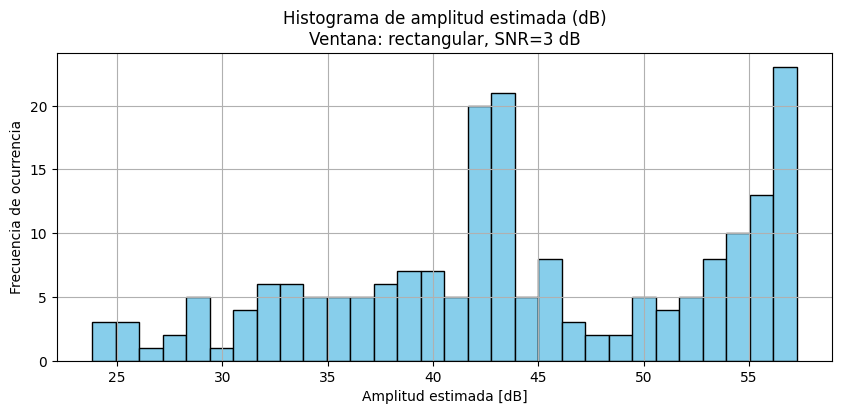

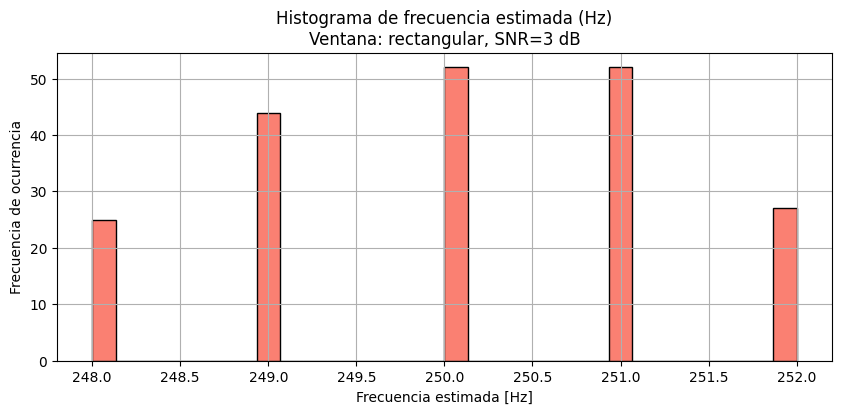

  Ventana: flattop

    Amplitud: sesgo=137.3501, var=306.7746
    Frecuencia: sesgo=-2.4164e-02, var=1.5144e+00



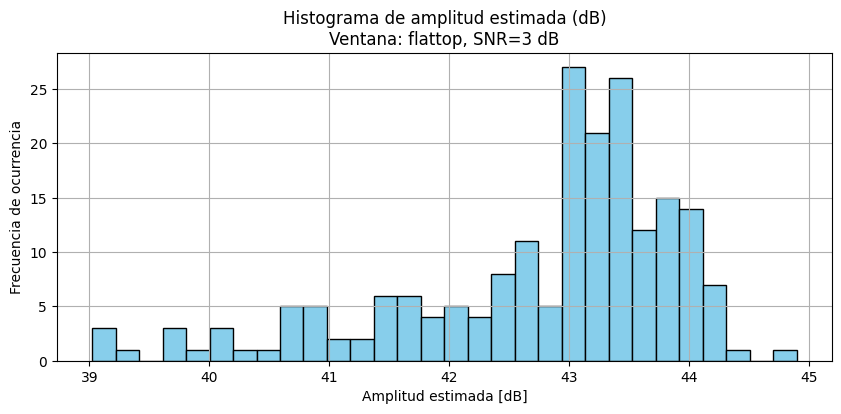

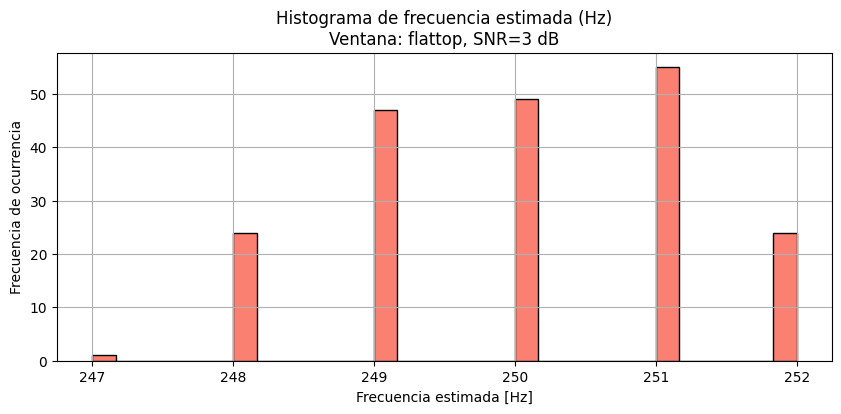

  Ventana: blackmanharris

    Amplitud: sesgo=163.2865, var=4636.3286
    Frecuencia: sesgo=-4.1636e-03, var=1.5030e+00



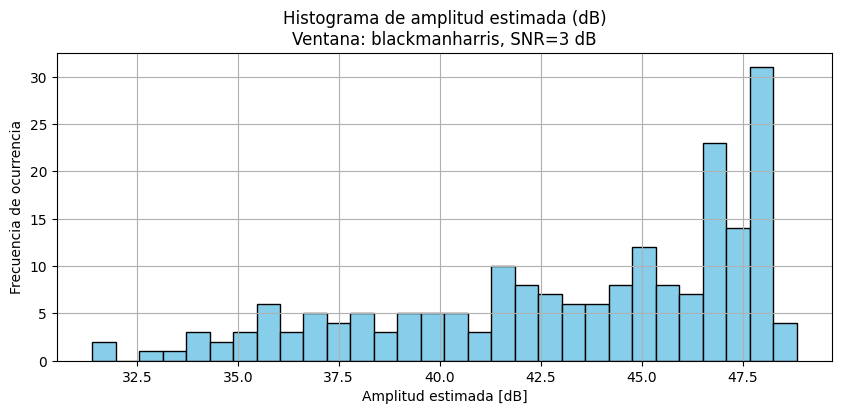

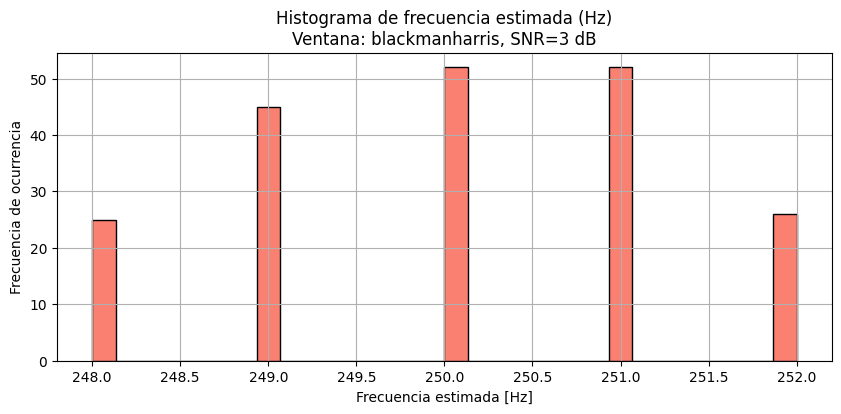

  Ventana: hann

    Amplitud: sesgo=177.3803, var=14954.8432
    Frecuencia: sesgo=8.3641e-04, var=1.4975e+00



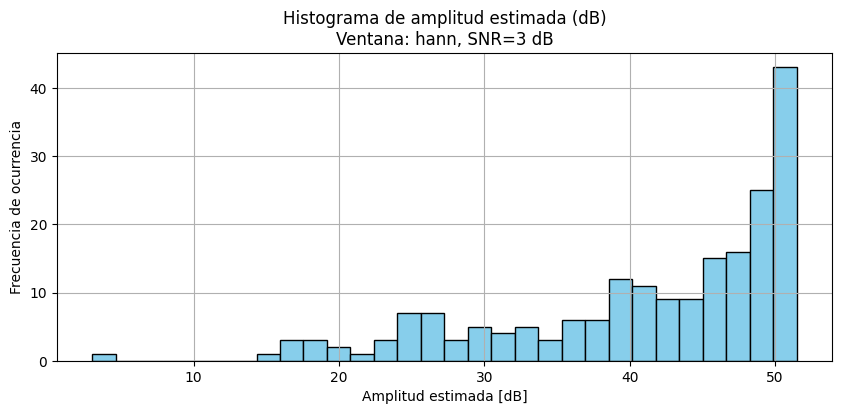

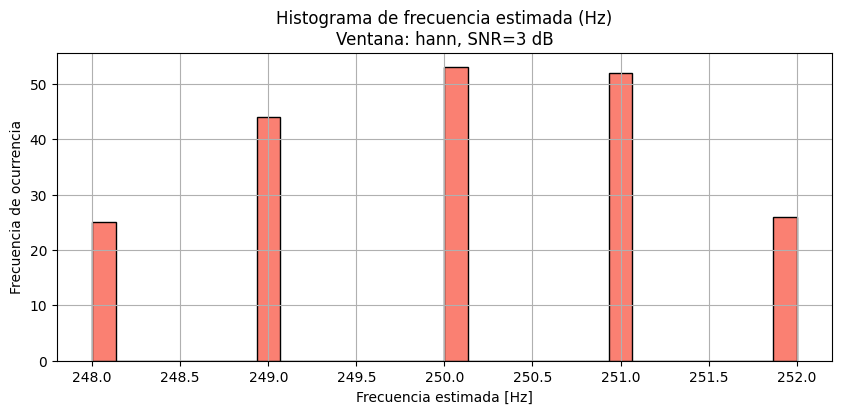


### Simulación con SNR = 10 dB ###

  Ventana: rectangular

    Amplitud: sesgo=277.7723, var=57039.0634
    Frecuencia: sesgo=1.6825e-02, var=1.5636e+00



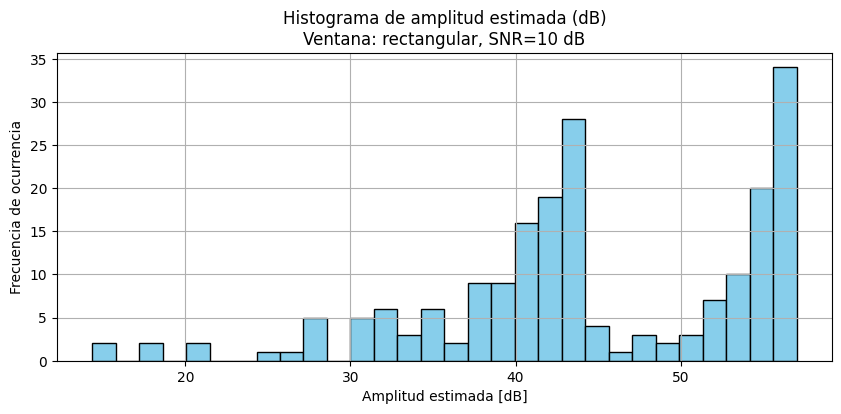

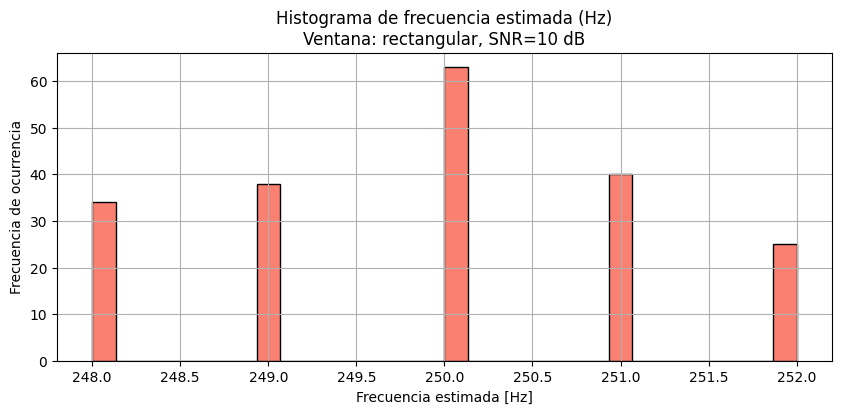

  Ventana: flattop

    Amplitud: sesgo=136.8974, var=262.5332
    Frecuencia: sesgo=-3.3175e-02, var=1.4931e+00



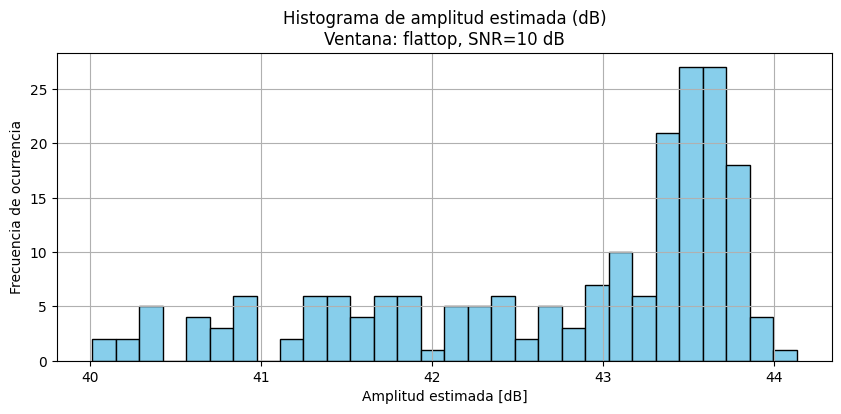

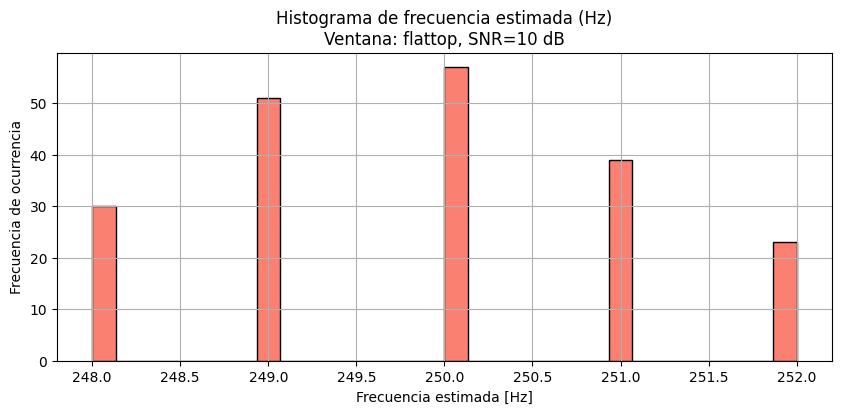

  Ventana: blackmanharris

    Amplitud: sesgo=163.3326, var=4903.8238
    Frecuencia: sesgo=6.8251e-03, var=1.5619e+00



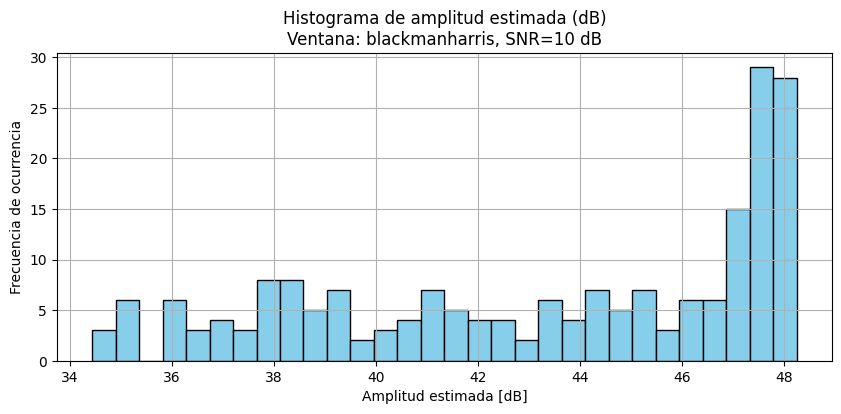

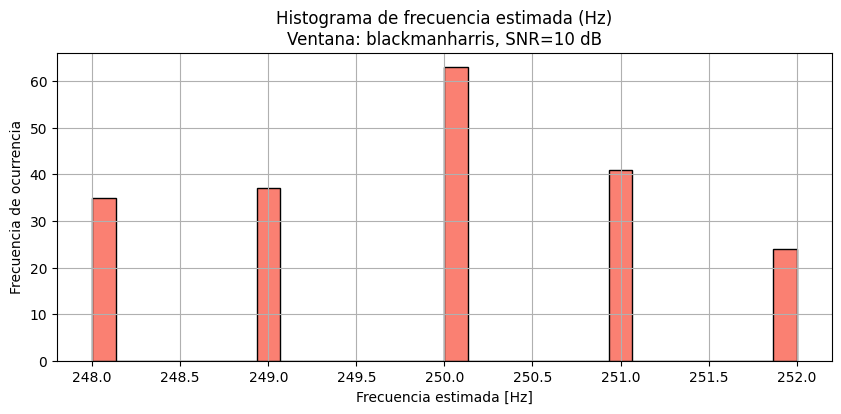

  Ventana: hann

    Amplitud: sesgo=177.4368, var=16551.6162
    Frecuencia: sesgo=1.6825e-02, var=1.5636e+00



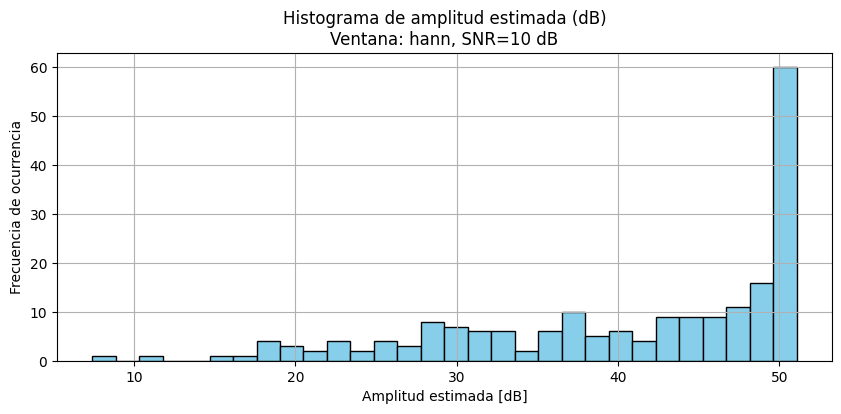

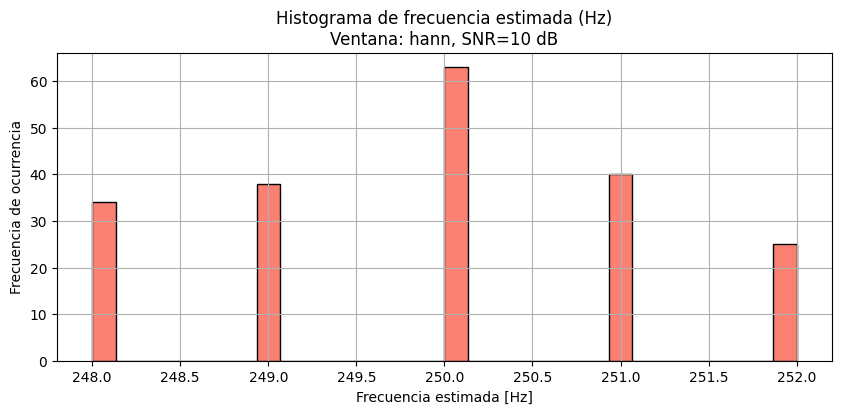

In [129]:
estimadores_show(SNR_dbs, ventanas, N_fft=N, normalizado="no") 

Se observa como varia drasticamente el sesgo y la varianza **afectando significativamente al estimador de amplitud** pero se mantiene practicamente **invariante para el estimador de frecuencia**. Esto se debe a que ambos fenomenos afectan de manera distinta a los estimadores: 

### ESTIMADOR DE AMPLITUD: 
- Cuando aplicás una **ventana** $w[n]$, estás multiplicando la señal por algo que no es constante (excepto la rectangular).Esa multiplicación en el tiempo equivale a una **convolución en frecuencia** entre el espectro ideal de la senoidal (un delta) y la transformada de la ventana.
- Como consecuencia, la energía de la senoidal se reparte produciendo que el pico principal disminuya.
- La magnitud del coeficiente DFT ya no corresponde directamente a la amplitud real de la señal, a menos que normalices por la ganancia de la ventana

Por eso el **estimador de amplitud es muy sensible** frente a cualquier ventana distinta a la rectangular se introduce un sesgo significativo si no se compensa.

### ESTIMADOR DE FRECUENCIA: 
- La ubicación del máximo espectral (el índice $k_0$) **no depende de la altura del lóbulo principal**, sino de su posición en el eje de frecuencias.
- Ni el zero-padding ni la normalización alteran esa posición:
    - El **zero-padding** solo interpola el espectro → más puntos en frecuencia, mejor definición numérica, pero no mueve el pico real.
    - La **normalización** es un escalado en magnitud → no cambia dónde está el máximo.
- Las ventanas influyen sobre la **resolución en frecuencia** (ancho del lóbulo principal y nivel de lóbulos laterales), pero no sobre la frecuencia central de la senoidal.

Es por eso el **estimador de frecuencia se mantiene prácticamente invariante**, salvo pequeñas variaciones si el pico cae “entre bins” y hay *leakage*.

A continuacion volveremos a realizar el experimento pero esta vez teniendo en cuenta ambos efectos:


### Simulación con SNR = 3 dB ###



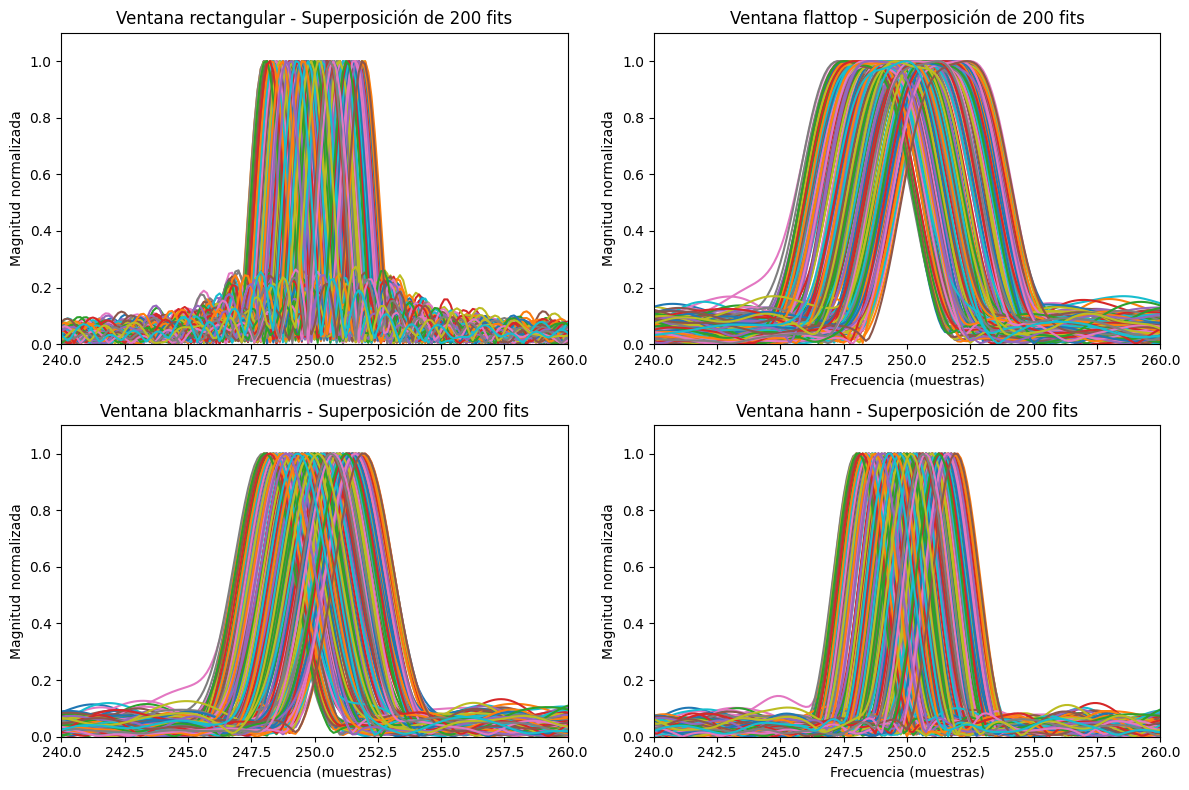


### Simulación con SNR = 10 dB ###



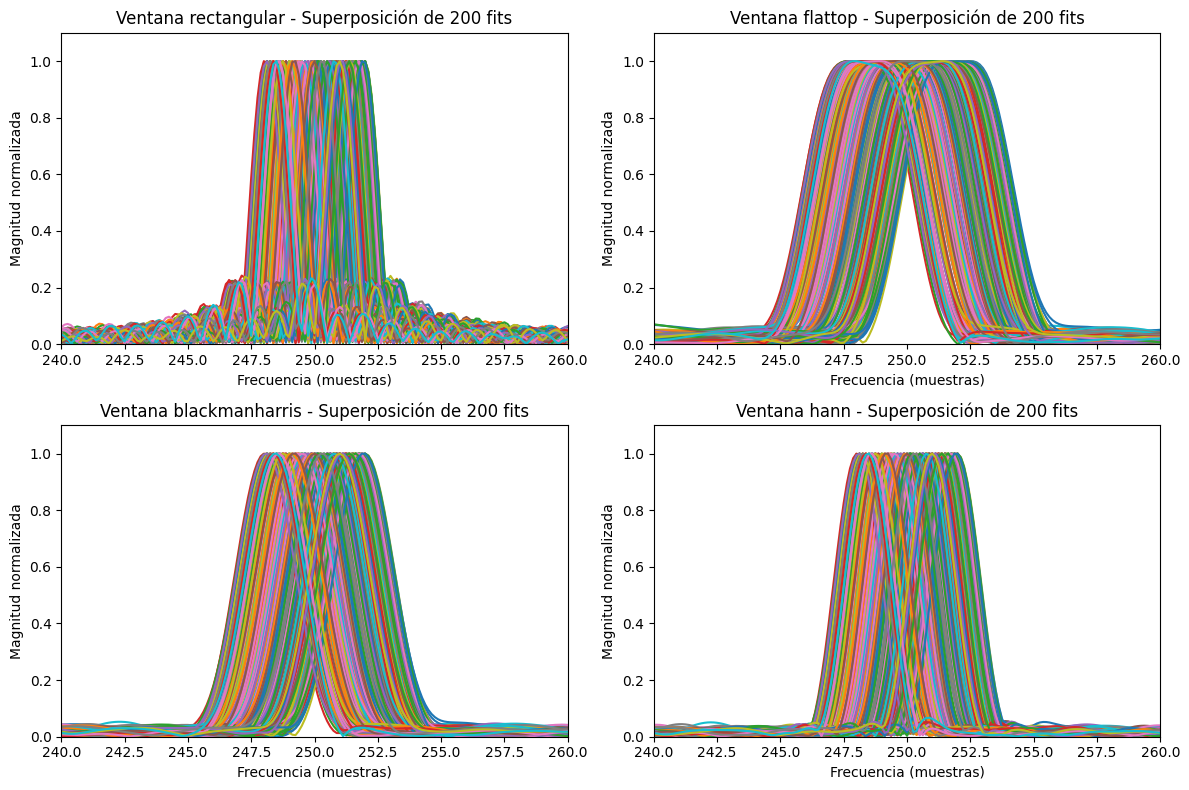

In [131]:
superposicion_show(SNR_dbs, N_fft=N*8) 


### Simulación con SNR = 3 dB ###

  Ventana: rectangular

    Amplitud: sesgo=-0.9192, var=0.1973
    Frecuencia: sesgo=-1.6912e-03, var=1.3526e+00



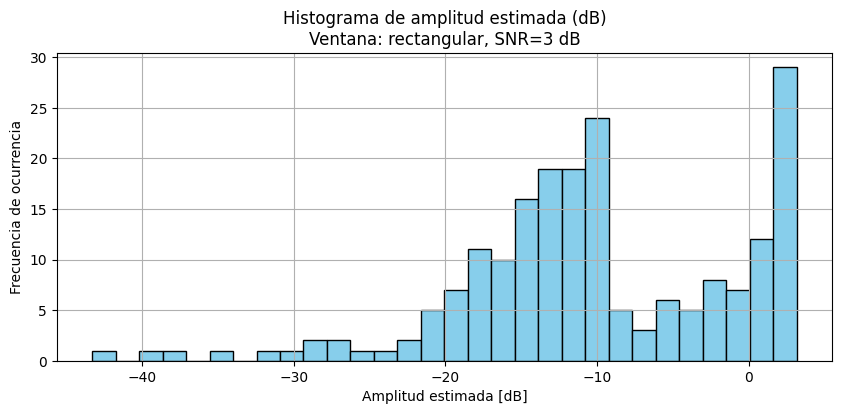

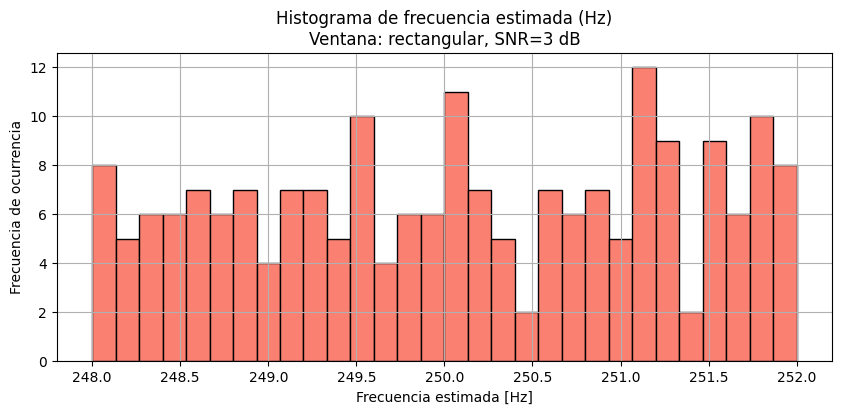

  Ventana: flattop

    Amplitud: sesgo=-0.1222, var=0.0254
    Frecuencia: sesgo=-6.6066e-02, var=1.6640e+00



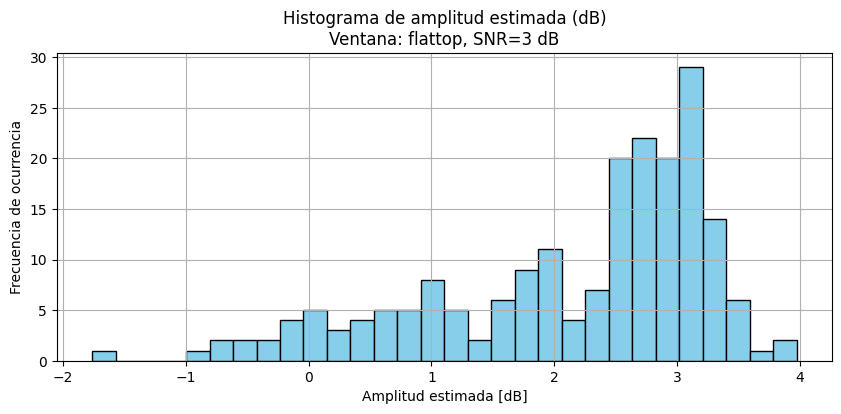

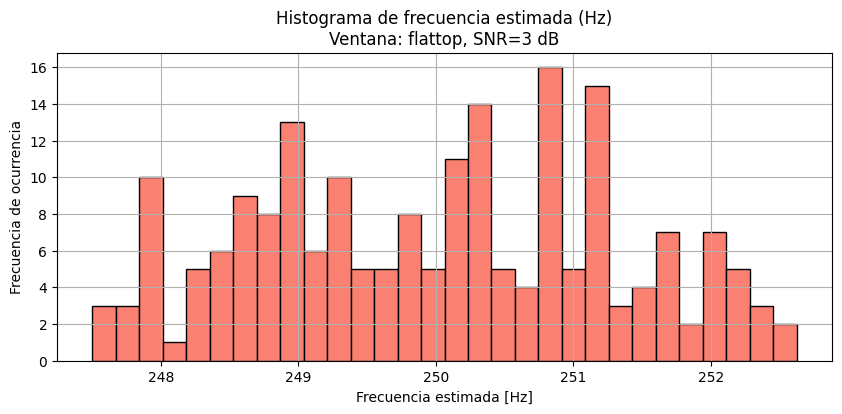

  Ventana: blackmanharris

    Amplitud: sesgo=-0.5029, var=0.1348
    Frecuencia: sesgo=-3.5662e-03, var=1.3712e+00



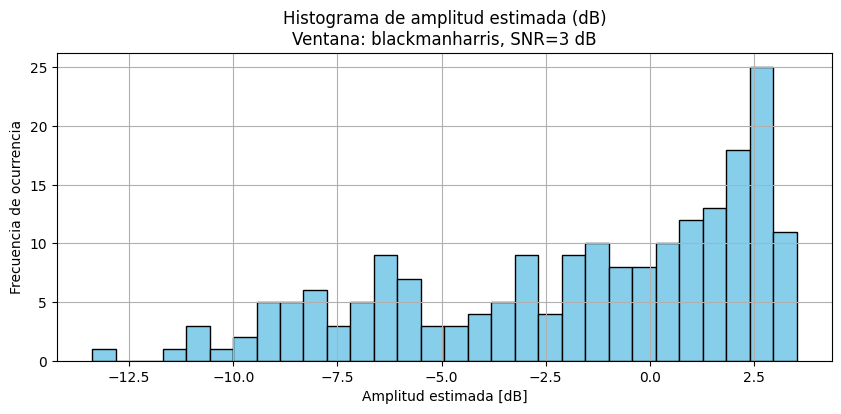

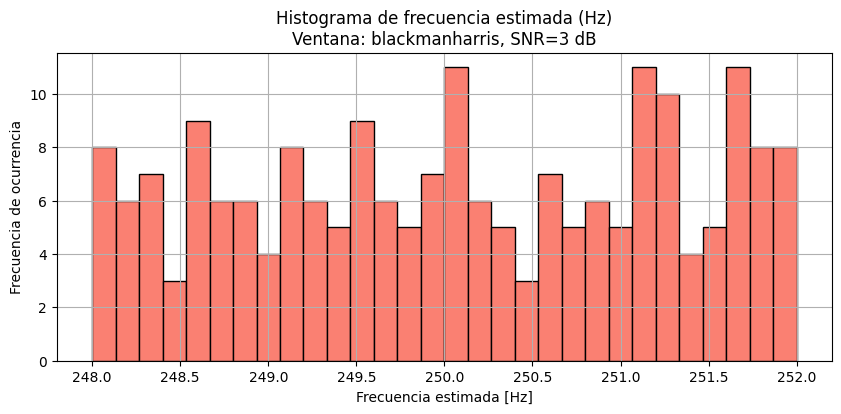

  Ventana: hann

    Amplitud: sesgo=-0.7157, var=0.2254
    Frecuencia: sesgo=-2.3162e-03, var=1.3628e+00



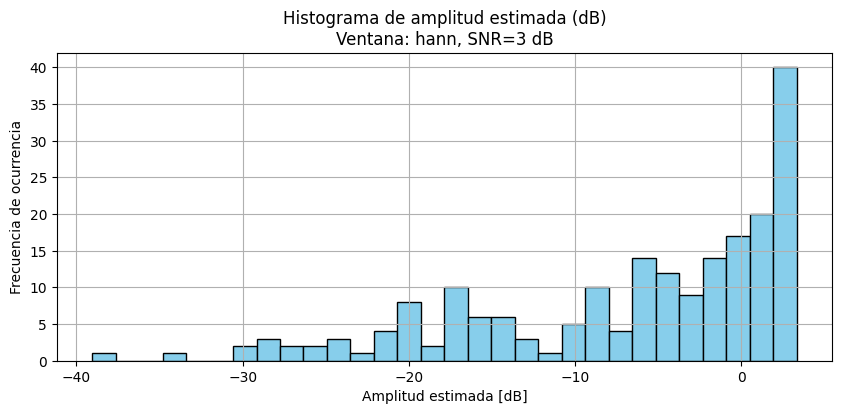

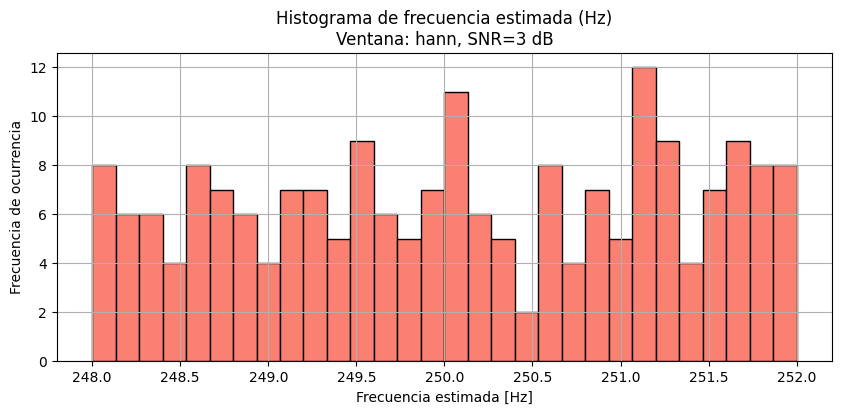


### Simulación con SNR = 10 dB ###

  Ventana: rectangular

    Amplitud: sesgo=-0.8927, var=0.2308
    Frecuencia: sesgo=-1.1837e-03, var=1.3290e+00



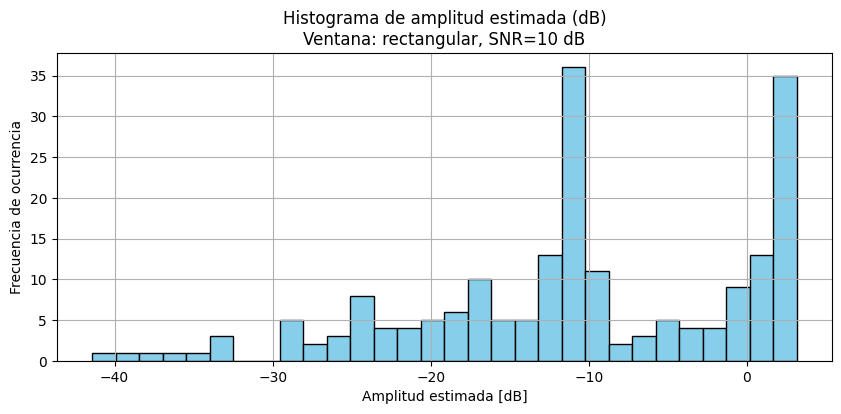

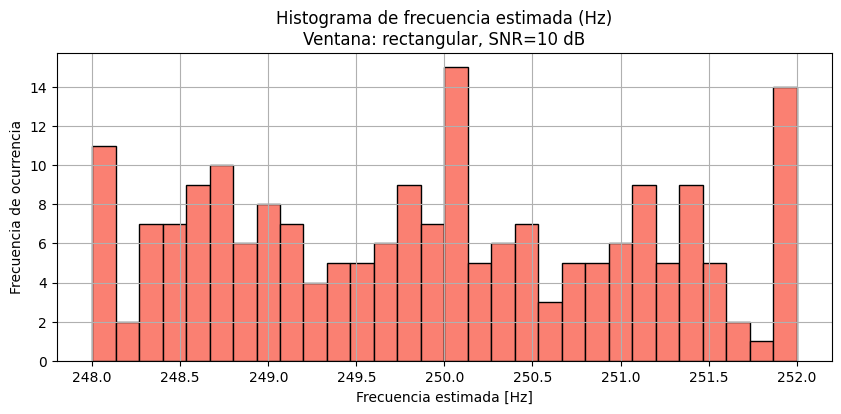

  Ventana: flattop

    Amplitud: sesgo=-0.1256, var=0.0239
    Frecuencia: sesgo=-5.5587e-03, var=1.5889e+00



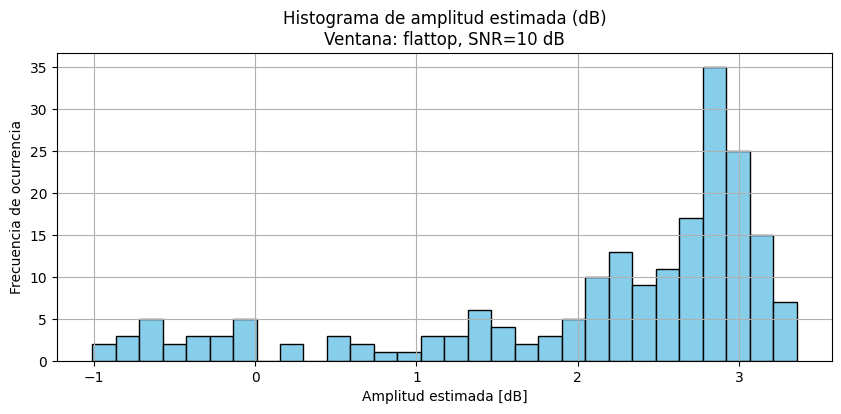

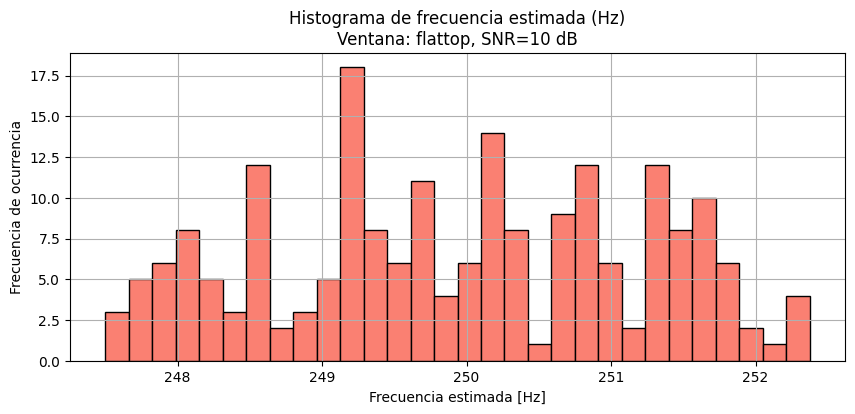

  Ventana: blackmanharris

    Amplitud: sesgo=-0.4896, var=0.1387
    Frecuencia: sesgo=-1.8087e-03, var=1.3260e+00



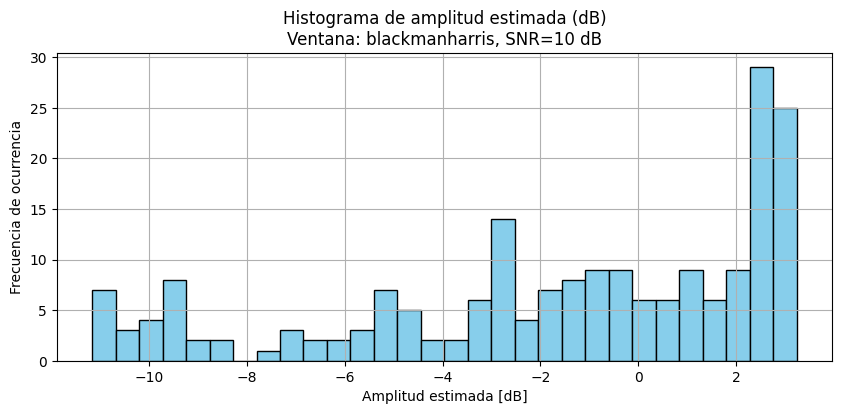

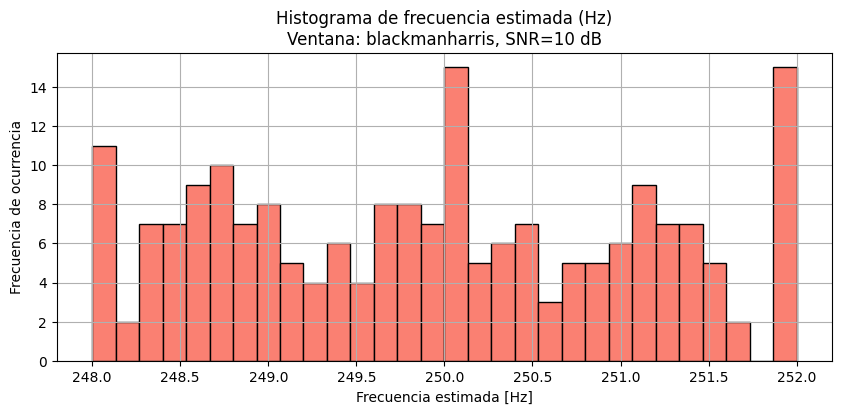

  Ventana: hann

    Amplitud: sesgo=-0.6949, var=0.2368
    Frecuencia: sesgo=1.3163e-03, var=1.3276e+00



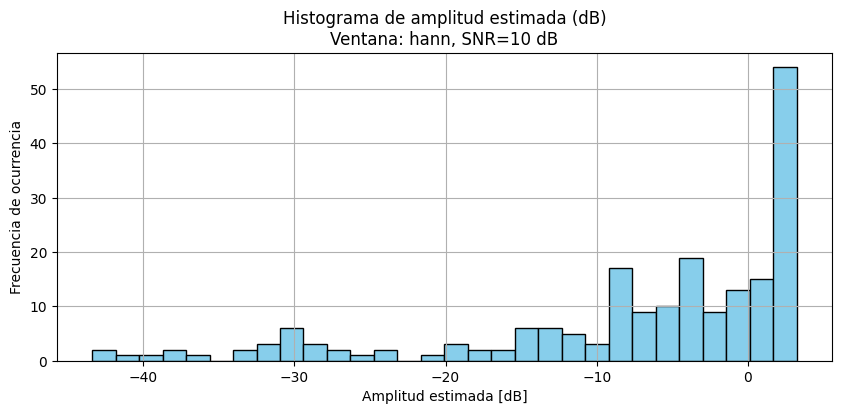

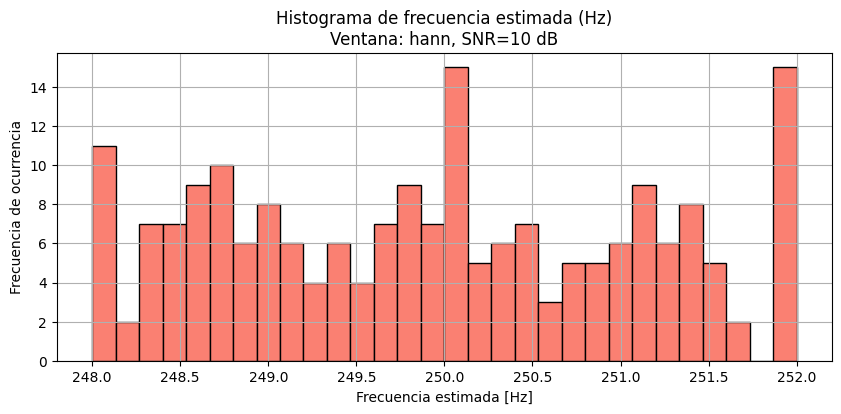

In [130]:
estimadores_show(SNR_dbs, ventanas, N_fft=N*8, normalizado="si") 